In [1]:
%matplotlib inline
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
cmap = plt.get_cmap("viridis")
from tqdm import tqdm

import config
from graph_models import FullGraphModel
from complete_training_data_processing import CompleteModelsDataProcessor
from model_inspection_funcs import neuron_data_from_image, propagate_neuron_data, sample_images

device = torch.device("cpu")
dtype = torch.float32

/home/eudald/Desktop/doctorat/connectome/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
data_processor = CompleteModelsDataProcessor(
    neurons=config.neurons,
    voronoi_criteria=config.voronoi_criteria,
    random_synapses=config.random_synapses,
    log_transform_weights=config.log_transform_weights,
)

model = FullGraphModel(
    input_shape=data_processor.number_of_synapses,
    num_connectome_passes=config.NUM_CONNECTOME_PASSES,
    decision_making_vector=data_processor.decision_making_vector,
    batch_size=config.batch_size,
    dtype=config.dtype,
    edge_weights=data_processor.synaptic_matrix.data,
    device=config.DEVICE,
    num_classes=len(config.CLASSES),
).to(device)

In [5]:
# horrible data stuff
connections = (
    pd.read_csv(
        "adult_data/connections.csv",
        dtype={
            "pre_root_id": "string",
            "post_root_id": "string",
            "syn_count": np.int32,
        },
    )
    .groupby(["pre_root_id", "post_root_id"])
    .sum("syn_count")
    .reset_index()
)
# set weights to 1 because we are not training
connections["weight"] = 1
right_root_ids = data_processor.right_root_ids
all_neurons = (
    pd.read_csv("adult_data/classification_clean.csv")
    .merge(right_root_ids, on="root_id")
    .fillna("Unknown")
)
neuron_data = pd.read_csv(
    "adult_data/right_visual_positions_selected_neurons.csv",
    dtype={"root_id": "string"},
).drop(columns=["x", "y", "z", "PC1", "PC2"])
data_cols = ["x_axis", "y_axis"]
all_coords = pd.read_csv("adult_data/all_coords_clean.csv", dtype={"root_id": "string"})
rational_cell_types = pd.read_csv("adult_data/rational_cell_types.csv")
all_neurons["decision_making"] = np.where(
    all_neurons["cell_type"].isin(rational_cell_types["cell_type"].values.tolist()),
    1,
    0,
)
all_neurons["root_id"] = all_neurons["root_id"].astype("string")

In [7]:
num_passes = 4
base_dir = "images/five_to_fifteen/train"
sub_dirs = ["yellow", "blue"]

sampled_images = sample_images(base_dir, sub_dirs, 100)

dms = {}
for img in tqdm(sampled_images):
    activated_data = neuron_data_from_image(img, neuron_data)
    propagation = propagate_neuron_data(
        activated_data, connections, all_coords, all_neurons, num_passes
    )
    dms[os.path.basename(img)] = propagation["decision_making"][
        all_neurons["decision_making"] == 1
    ]
data = pd.DataFrame(dms)

100%|██████████| 200/200 [09:00<00:00,  2.70s/it]


In [10]:
means = pd.DataFrame(data.mean(axis=0))
means = means.rename(columns={0: "mean"})
means["yellow"] = [int(a.split("_")[1]) for a in means.index]
means["blue"] = [int(a.split("_")[2]) for a in means.index]
means["color"] = means[["yellow", "blue"]].idxmax(axis=1)

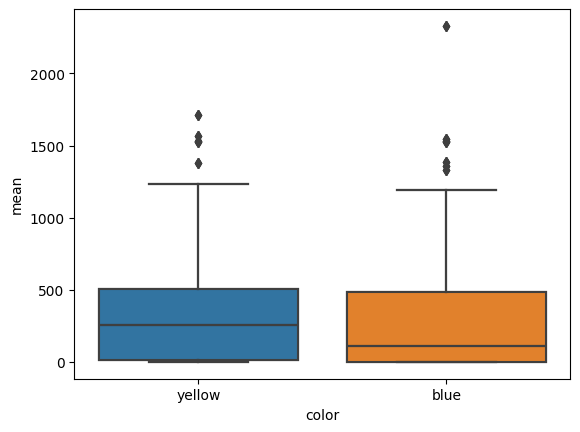

In [13]:
# boxplot of mean depending on color using seaborn
%matplotlib inline
import seaborn as sns

sns.boxplot(x="color", y="mean", data=means)
plt.show()

In [15]:
means["pred"] = np.where(means["mean"] > means["mean"].mean(), "yellow", "blue")

In [17]:
# confusion matrix between color and pred
from sklearn.metrics import confusion_matrix

confusion_matrix(means["color"], means["pred"]) / len(means)

array([[0.345, 0.155],
       [0.275, 0.225]])

In [18]:
print(f"accuracy = {np.mean(means['color'] == means['pred'])}")

accuracy = 0.57
